## I imported all the necesary data and downloaded a file of profit data for movies 

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import json
import sqlite3
import numpy as np
%matplotlib inline
from PIL import Image
import seaborn as sns

thenums_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')


## I made a function that turned object columns into integer colums ###

I ran this function onto the columns of this dataframe


In [2]:
# This function turns series columns into integers
def make_column_integer(df, series):
    df[series] = df[series].str.replace('$', '')
    df[series] = df[series].str.replace(',', '')
    df[series] = df[series].astype(int)

# Turns all the columns in this dataframe into integers
make_column_integer(thenums_df, 'production_budget')
make_column_integer(thenums_df, 'domestic_gross')
make_column_integer(thenums_df, 'worldwide_gross')

<ipython-input-2-a2a5e9ebbbc4>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[series] = df[series].str.replace('$', '')



## I then made 2 new columns: 

One column called "total_gross" which was the sum of the domestic and worldwide grossings, and another column called "total_profit" that is the total gross minus the production cost.



In [3]:
thenums_df['total_profit'] = (thenums_df['worldwide_gross']-thenums_df['production_budget'])
thenums_df.sort_values('total_profit', ascending = False, inplace=True)

# I imported a new dataframe from the IMDB database that contained the genres of the movies.

In [4]:
imdb_title_basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')



# I merged the profits dataframe and the title basics dataframe



In [5]:
master_movies_df = pd.merge(imdb_title_basics, thenums_df, how='inner', left_on='primary_title', right_on='movie')

In [6]:
# Sorted the values by hightest profit
master_movies_df = master_movies_df.sort_values('total_profit', ascending=False)

In [7]:
# Drops redundant columns
master_movies_df = master_movies_df.drop(columns = ['original_title', 'start_year', 'id', 'movie'])

In [8]:
# Drops the duplicated movies from the dataframe
master_movies_df = master_movies_df.drop_duplicates(subset='primary_title')

In [9]:
#Sets the index to their tconst
master_movies_df.set_index('tconst', inplace=True)

In [10]:
#Drops all null values from the genres catagory
master_movies_df.dropna(subset=['genres'], inplace=True)

In [11]:
master_movies_df.at['tt1775309', 'genres'] = 'Action,Adventure,Fantasy'

# This saves the master_movies_df DataFrame into a CSV File

In [12]:
master_movies_df.to_csv('master_movie_database')
pd.read_csv('master_movie_database')

,tconst,primary_title,runtime_minutes,genres,release_date,production_budget,domestic_gross,worldwide_gross,total_profit
0,tt1775309,Avatar,93.0,"Action,Adventure,Fantasy","Dec 18, 2009",425000000,760507625,2776345279,2351345279
1,tt8852130,Titanic,115.0,Family,"Dec 19, 1997",200000000,659363944,2208208395,2008208395
2,tt4154756,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi","Apr 27, 2018",300000000,678815482,2048134200,1748134200
3,tt0369610,Jurassic World,124.0,"Action,Adventure,Sci-Fi","Jun 12, 2015",215000000,652270625,1648854864,1433854864
4,tt2820852,Furious 7,137.0,"Action,Crime,Thriller","Apr 3, 2015",190000000,353007020,1518722794,1328722794
...,...,...,...,...,...,...,...,...,...
2282,tt7504726,Call of the Wild,NaN,"Adventure,Animation,Family","Feb 21, 2020",82000000,0,0,-82000000
2283,tt5519340,Bright,117.0,"Action,Crime,Fantasy","Dec 13, 2017",90000000,0,0,-90000000
2284,tt2283336,Men in Black: International,115.0,"Action,Adventure,Comedy","Jun 14, 2019",110000000,3100000,3100000,-106900000
2285,tt1305591,Mars Needs Moms,88.0,"Adventure,Animation,Family","Mar 11, 2011",150000000,21392758,39549758,-110450242


# I made a list of all possible genres for each movie

In [13]:
# Puts all the genres for each movie into a list
list_of_genres = master_movies_df['genres']
list_of_genres = list_of_genres.str.split(',')

In [14]:
nunique_genres=[]
for x in list_of_genres:
    for genre in x:
        nunique_genres.append(genre)

unique_genres = set(nunique_genres)

## I cleaned up and seperated the total movie database
### I moved all the movies with no gross earnings into a database called "stream_movies", and I took all the others and named the new database "theater_movies"

In [15]:
stream_movies = master_movies_df.loc[master_movies_df['worldwide_gross']== 0]
stream_movies = stream_movies.sort_values(by='production_budget', ascending=False)
stream_movies = stream_movies.drop(['domestic_gross','worldwide_gross','total_profit'], axis='columns')

In [16]:
theater_movies = master_movies_df[master_movies_df.worldwide_gross != 0]

## I made CSV files out of theater movies and streamed movies

In [17]:
theater_movies.to_csv('all_theater_movies_df')
stream_movies.to_csv('all_streamed_movies_df')

# I then broke up the dataframe into sub-dataframes, for each genre we are analyzing.
#### I then broke up the genre dataframes into theatrical releases and streaming releases


In [18]:
action_movies= theater_movies[theater_movies.genres.str.contains('Action' or 'Adventure')]
drama_movies= theater_movies[theater_movies.genres.str.contains('Drama')]
comedy_movies= theater_movies[theater_movies.genres.str.contains('Comedy')]
horror_movies= theater_movies[theater_movies.genres.str.contains('Horror')]

In [19]:
action_movies_st= stream_movies[stream_movies.genres.str.contains('Action' or 'Adventure')]
drama_movies_st= stream_movies[stream_movies.genres.str.contains('Drama')]
comedy_movies_st= stream_movies[stream_movies.genres.str.contains('Comedy')]
horror_movies_st= stream_movies[stream_movies.genres.str.contains('Horror')]

## This Function turns the dataframes into CSV files

In [20]:
def make_csv(data, file_name):
    filename = data.to_csv(file_name)
    return filename

# This WebScrapes the taglines from IMDb for each movie
### It then organizes the first five taglines into a list for each movie

In [21]:
def get_tags(data):
    no_table = []
    list_of_tags = []
    for tconst in data.index:
        url = f'https://www.imdb.com/title/{tconst}/keywords?ref_=tt_stry_kw'
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'lxml')
        
        try:
            table = soup.find_all('table', {'class': 'dataTable'})[0]
            a_tags = [x.find('a') for x in table.find_all('td', {'class': 'soda sodavote'})]
            if len([x.text for x in a_tags]) > 5:
                text = [x.text for x in a_tags][:5]
            else:
                text = [x.text for x in a_tags]
        
            list_of_tags.append(text)
        
        except:
            no_table.append(tconst)
            list_of_tags.append([None])
  
    return list_of_tags

### I ran this web scraping function on my 4 dataframes

In [22]:
horror_tags = get_tags(horror_movies)

In [23]:
action_tags = get_tags(action_movies)

In [24]:
comedy_tags = get_tags(comedy_movies)

In [25]:
drama_tags = get_tags(drama_movies)

In [26]:
# horror_movies['tags'] = horror_tags
# comedy_movies['tags'] = comedy_tags
# action_movies['tags'] = action_tags
# drama_movies['tags'] = drama_tags

In [27]:
make_csv(action_movies, 'action_movies_df')
make_csv(comedy_movies, 'comedy_movies_df')
make_csv(drama_movies, 'drama_movies_df')
make_csv(horror_movies, 'horror_movies_df')

make_csv(action_movies_st, 'action_movies_st_df')
make_csv(comedy_movies_st, 'comedy_movies_st_df')
make_csv(drama_movies_st, 'drama_movies_st_df')
make_csv(horror_movies_st, 'horror_movies_st_df')

# This Function makes a string of all the titles for a Word Cloud

In [28]:
def make_list_of_titles(df):
    list_of_titles = list(df['primary_title'])
    titlestring = ' '.join(list_of_titles)

In [29]:
action_titles = make_list_of_titles(successful_action)
comedy_titles = make_list_of_titles(successful_comedy)
drama_titles = make_list_of_titles(successful_drama)
horror_titles = make_list_of_titles(successful_horror)

NameError: name 'successful_action' is not defined

  
# A function that creates a new dataframe for each genre (where the profits for each movie are over $1,000,000)
 

In [30]:
def get_successful(df):
    df_successes = df.loc[df['total_profit'] > 1000000]
    return df_successes

In [31]:
successful_action = get_successful(action_movies)

In [32]:
successful_comedy = get_successful(comedy_movies)

In [33]:
successful_drama = get_successful(drama_movies)

In [34]:
successful_horror = get_successful(horror_movies)

#### A funtion that spits out a dataframe for each genre of movie

In [35]:
def get_genre_db(db, genre):
    return db[db["genres"].str.contains(genre)]

#### A function that gets the median value for profit earned for a given genre

In [36]:
def get_median():
    list_of_med_nums= []
    for genre in unique_genres:
        list_of_med_nums.append(get_genre_db(master_movies_df, genre).describe()['total_profit']['50%'])
    #list_of_meds = list(zip(unique_genres,list_of_med_nums))
    return list_of_med_nums

# This Function removes the null values from the tag lists for each genre, and makes it into one list of all the tags

In [37]:
def removenulls(tag_list):
    for x in tag_list:
        if None in x:
            tag_list.remove(x)
    return tag_list

In [38]:
horror_tags_nonull = removenulls(horror_tags)
comedy_tags_nonull = removenulls(comedy_tags)
action_tags_nonull = removenulls(action_tags)
drama_tags_nonull = removenulls(drama_tags)

### Lists all tags in one list

In [39]:
def list_all_tags(tag_list):
    all_tags = []
    for tags in tag_list:
        for tag in tags:
                all_tags.append(tag)
    return all_tags

# Those lists were transformed into strings for the Word Cloud

In [40]:
all_horror_tags = list_all_tags(horror_tags_nonull)
all_drama_tags = list_all_tags(drama_tags_nonull)
all_comedy_tags = list_all_tags(comedy_tags_nonull)
all_action_tags = list_all_tags(action_tags_nonull)

In [41]:
def tt(all_tags):
    for x in range(len(all_tags)):
        all_tags[x] = all_tags[x].title()
        all_tags[x] = all_tags[x].replace(' ','_')
    return ' '.join(all_tags)
     

In [42]:
horror_tt = tt(all_horror_tags)
drama_tt = tt(all_drama_tags)
comedy_tt = tt(all_comedy_tags)
action_tt = tt(all_action_tags)

AttributeError: 'NoneType' object has no attribute 'title'

# The World Cloud for each genre's tags

In [43]:
#create the wordcloud object
plt.figure(figsize=(15,15))
action_wordcloud = WordCloud(width = 1000, height = 1000, max_words=30, background_color = 'lemonchiffon',
                      collocations=True, colormap = 'gist_heat', prefer_horizontal = 1, max_font_size = 150).generate(action_tt)

#plot the wordcloud object
plt.imshow(action_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined

<Figure size 1080x1080 with 0 Axes>

In [44]:
#create the wordcloud object
plt.figure(figsize=(15,15))
horror_wordcloud = WordCloud(width = 1000, height = 1000, max_words=20, background_color = 'black',
                      collocations=True, colormap = 'RdPu_r', prefer_horizontal = 1).generate(horror_tt)

#plot the wordcloud object
plt.imshow(horror_wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined

<Figure size 1080x1080 with 0 Axes>

In [45]:
#create the wordcloud object
plt.figure(figsize=(15,15))
comedy_wordcloud = WordCloud(width = 1000, height = 1000, max_words=20, background_color = 'ivory',
                      collocations=True, colormap = 'Wistia', prefer_horizontal = 1 ).generate(comedy_tt)

#plot the wordcloud object
plt.imshow(comedy_wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined

<Figure size 1080x1080 with 0 Axes>

In [46]:
#create the wordcloud object
plt.figure(figsize=(15,15))
drama_wordcloud = WordCloud(width = 1000, height = 1000, max_words=20, background_color = 'white',
                      collocations=True, colormap = 'RdBu_r', prefer_horizontal = 1).generate(drama_tt)

#plot the wordcloud object
plt.imshow(drama_wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined

<Figure size 1080x1080 with 0 Axes>

# Histograms of runtimes for the successful movies in each genre

/Users/gabrielwarner/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


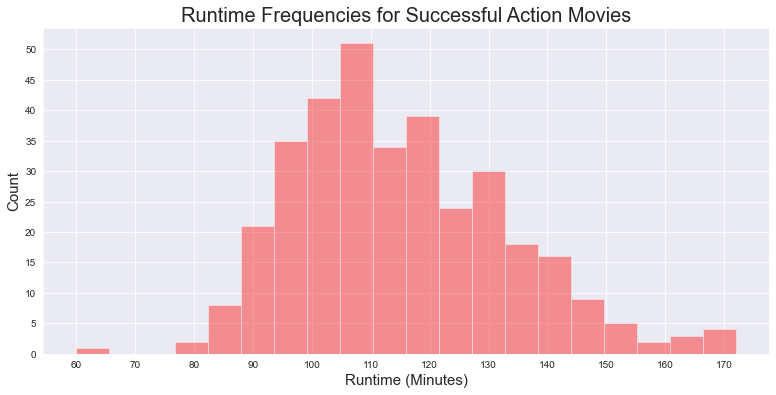

In [47]:
sns.set_style('darkgrid')


actionfighist,actionaxhist = plt.subplots(figsize=(13,6))
sns.distplot(successful_action['runtime_minutes'], kde=False, bins = 20, color='red');
actionaxhist.set_xlabel('Runtime (Minutes)', fontsize=15)
actionaxhist.set_ylabel('Count', fontsize=15)
actionaxhist.set_title(f'Runtime Frequencies for Successful Action Movies', fontsize = 20)
plt.locator_params(axis='y', nbins = 15 )
plt.locator_params(axis='x', nbins = 20 )

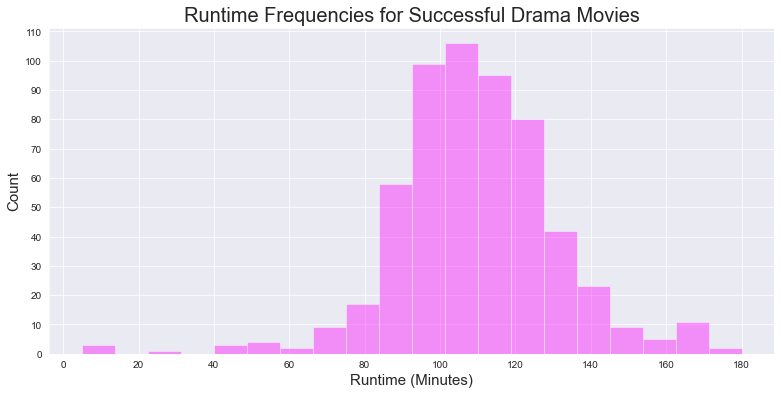

In [48]:
dramafighist,dramaaxhist = plt.subplots(figsize=(13,6))
sns.distplot(successful_drama['runtime_minutes'], kde=False, bins = 20, color='magenta');
dramaaxhist.set_xlabel('Runtime (Minutes)', fontsize=15)
dramaaxhist.set_ylabel('Count', fontsize=15)
dramaaxhist.set_title(f'Runtime Frequencies for Successful Drama Movies', fontsize = 20)
plt.locator_params(axis='x', nbins = 15 )
plt.locator_params(axis='y', nbins = 20 )

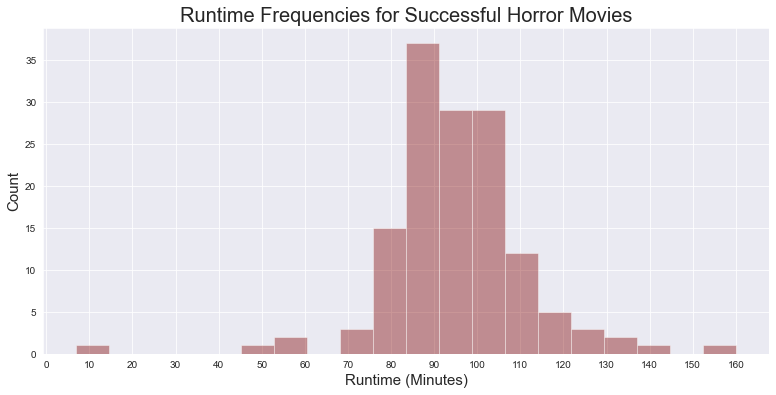

In [49]:
horrorfighist,horroraxhist = plt.subplots(figsize=(13,6))
sns.distplot(successful_horror['runtime_minutes'], kde=False, bins = 20, color='maroon');
horroraxhist.set_xlabel('Runtime (Minutes)', fontsize=15)
horroraxhist.set_ylabel('Count', fontsize=15)
horroraxhist.set_title(f'Runtime Frequencies for Successful Horror Movies', fontsize = 20)
plt.locator_params(axis='y', nbins = 15 )
plt.locator_params(axis='x', nbins = 20)

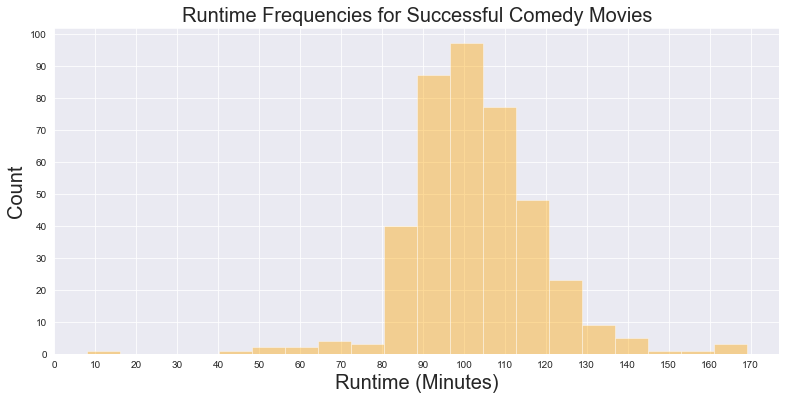

In [50]:
comedyfighist,comedyaxhist = plt.subplots(figsize=(13,6))
sns.distplot(successful_comedy['runtime_minutes'], kde=False, bins = 20, color='orange');
comedyaxhist.set_xlabel('Runtime (Minutes)', fontsize=20)
comedyaxhist.set_ylabel('Count', fontsize=20)
comedyaxhist.set_title(f'Runtime Frequencies for Successful Comedy Movies', fontsize = 20)
plt.locator_params(axis='y', nbins = 15)
plt.locator_params(axis='x', nbins = 20 )

# Comparison of budget and profit

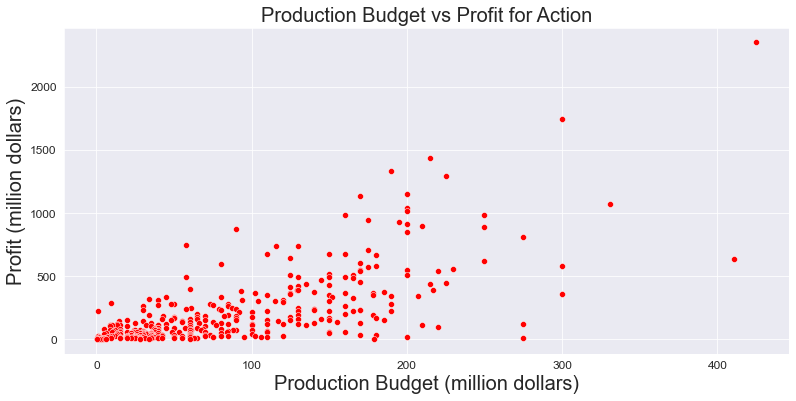

In [51]:
actionfigscat, actionaxscat = plt.subplots(figsize = (13,6))
sns.scatterplot(x = (successful_action['production_budget']/1000000), y = (successful_action['total_profit']/1000000), color='red')
actionaxscat.set_xlabel('Production Budget (million dollars)', fontsize=20)
actionaxscat.set_ylabel('Profit (million dollars)', fontsize=20)
actionaxscat.set_title('Production Budget vs Profit for Action', fontsize = 20)
actionaxscat.tick_params(axis='x', labelsize= 12)
actionaxscat.tick_params(axis='y', labelsize= 12)

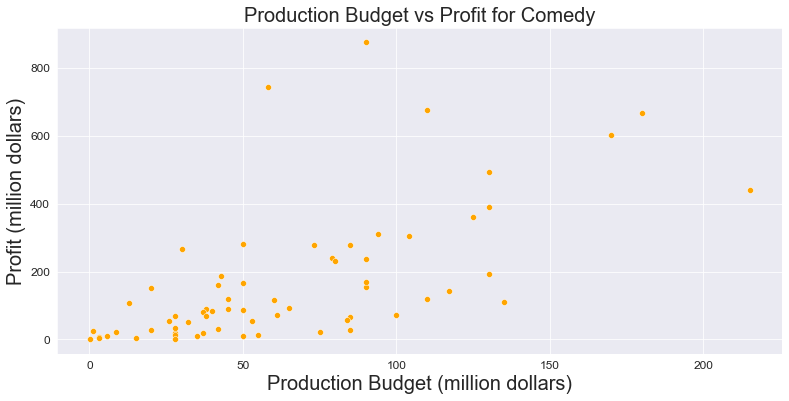

In [52]:
comedyfigscat, comedyaxscat = plt.subplots(figsize = (13,6))
sns.scatterplot(x = (successful_comedy['production_budget']/1000000), y = (successful_action['total_profit']/1000000), color='orange')
comedyaxscat.set_xlabel('Production Budget (million dollars)', fontsize=20)
comedyaxscat.set_ylabel('Profit (million dollars)', fontsize=20)
comedyaxscat.set_title('Production Budget vs Profit for Comedy', fontsize = 20)
comedyaxscat.tick_params(axis='x', labelsize= 12)
comedyaxscat.tick_params(axis='y', labelsize= 12)

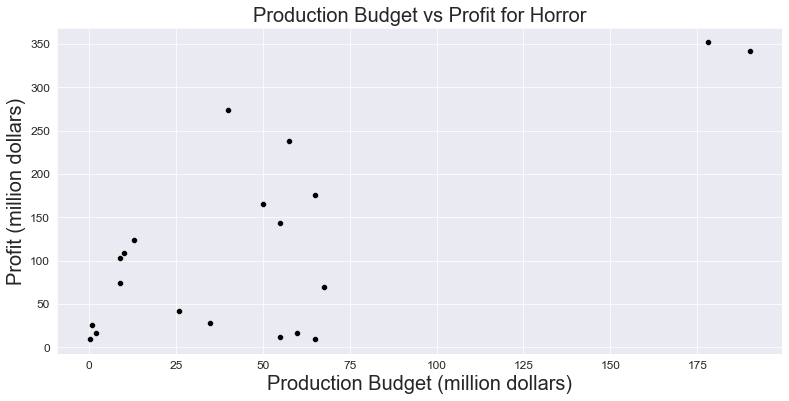

In [53]:
horrorfigscat, horroraxscat = plt.subplots(figsize = (13,6))
sns.scatterplot(x = (successful_horror['production_budget']/1000000), y = (successful_action['total_profit']/1000000), color='black')
horroraxscat.set_xlabel('Production Budget (million dollars)', fontsize=20)
horroraxscat.set_ylabel('Profit (million dollars)', fontsize=20)
horroraxscat.set_title('Production Budget vs Profit for Horror', fontsize = 20)
horroraxscat.tick_params(axis='x', labelsize= 12)
horroraxscat.tick_params(axis='y', labelsize= 12)

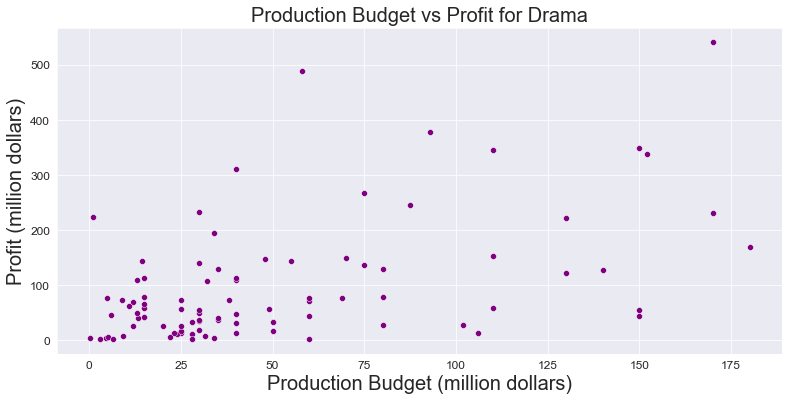

In [54]:
dramafigscat, dramaaxscat = plt.subplots(figsize = (13,6))
sns.scatterplot(x = (successful_drama['production_budget']/1000000), y = (successful_action['total_profit']/1000000), color='purple')
dramaaxscat.set_xlabel('Production Budget (million dollars)', fontsize=20)
dramaaxscat.set_ylabel('Profit (million dollars)', fontsize=20)
dramaaxscat.set_title('Production Budget vs Profit for Drama', fontsize = 20)
dramaaxscat.tick_params(axis='x', labelsize= 12, )
dramaaxscat.tick_params(axis='y', labelsize= 12)

# Added Rotten Tomatoes data to each genre's data frame for more analysis

In [55]:
tomatoes_data = pd.read_csv('data/ZippedData/rotten_tomatoes_movies.csv.gz')

In [56]:
def add_data(df):
    df_more_data = pd.merge(df, tomatoes_data, how='inner', left_on='primary_title', right_on='movie_title')
    return df_more_data

In [57]:
successful_horror_moredata = add_data(successful_horror)
successful_comedy_moredata = add_data(successful_comedy)
successful_action_moredata = add_data(successful_action)
successful_drama_moredata = add_data(successful_drama)

## Dropped irrelevant columns

In [58]:
def drop_irrelevant_columns(df):
    columns_needed = ['primary_title', 'runtime_minutes', 'genres_x', 'release_date',
                       'production_budget', 'domestic_gross', 'worldwide_gross',
                       'total_profit', 'content_rating', 'directors', 'actors']
    return df[columns_needed]

In [59]:
successful_action_moredata = drop_irrelevant_columns(successful_action_moredata)
successful_comedy_moredata = drop_irrelevant_columns(successful_comedy_moredata)
successful_drama_moredata = drop_irrelevant_columns(successful_drama_moredata)
successful_horror_moredata = drop_irrelevant_columns(successful_horror_moredata)